# Lecture 15 - Mechanistic modeling

In this lecture you learned about using ordinary differential equations (ODEs) to build mechanistic models of biological systems. In this tutorial we will build a simple model and use it to run simulations.

## Exercise 0: warm-up

Let's say we have two very simple chemical reactions: 
 - $R_1: A \to B$ with the kinetic rate: $r_1 = k_1 A$
 - $R_2: B \to C$ with the kinetic rate: $r_2 = k_2 B$
 
This leads to the following ODE model:

 - $\frac{dA}{dt} = -r_1$ 
 - $\frac{dB}{dt} = r_1 - r_2$
 - $\frac{dC}{dt} = r_2$ 
 
Let's say the initial concentrations are [A] = 10 mM, [B] = 0 mM, [C] = 0 mM, and the parameter values are $k_1 = 0.1 s^{-1}, k_2 = 0.05 s^{-1}$.

We can implement the model as follows:

In [4]:
def ode(t, X):
    
    # unpack the values from vector X
    a, b, c = X 
    
    # define the parameter values
    k1, k2 = 0.1, 0.05 
    
    # calculate the reaction rates
    r1 = k1 * a
    r2 = k2 * b
    
    # calculate the derivatives
    da = -r1
    db = r1 - r2
    dc = r2
    
    # return the derivatives as a single vector
    dX = [da, db, dc]
    return dX

X0 = [10, 0, 0]

We can now use function [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to simulate the system by integrating the ODE over a given time span. 

> You will notice that we defined time (`t`) as an argument in the ODE function. 
> That's because *solve_ivp* is expecting a function with a signature `dX/dt = f(t, X)`. 
> We could use it to model events that depend explicitly on time. 

In [5]:
from scipy.integrate import solve_ivp

time_span = [0, 100] 

solution = solve_ivp(ode, time_span, X0)

Let's plot the simulation to see what it looks like:

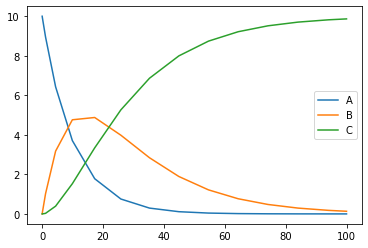

In [7]:
import matplotlib.pyplot as plt

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

You will notice that the curves are not that smooth. We can try a different integration method:

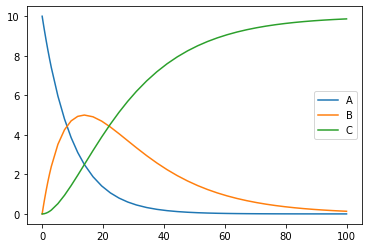

In [15]:
solution = solve_ivp(ode, time_span, X0, method='BDF')

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

Ok, that looks better. But now we would like to see how changing the parameters would affect the solutions. 

Unfortunetely, we have *hard-coded* the parameter values inside the ODE function. We should instead make them arguments of the equation:

In [39]:
def ode(t, X, k1, k2):
    
    # unpack the values from vector X
    a, b, c = X 
    
    # calculate the reaction rates
    r1 = k1 * a
    r2 = k2 * b
    
    # calculate the derivatives
    da = -r1
    db = r1 - r2
    dc = r2
    
    # return the derivatives as a single vector
    dX = [da, db, dc]
    return dX

Now we can run a simulation with different parameter values:

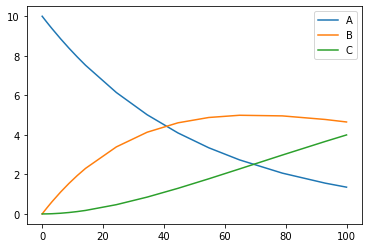

In [40]:
k1, k2 = 0.02, 0.01

solution = solve_ivp(ode, time_span, X0, method='BDF', args=(k1, k2))

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

Perfect, now we are warmed-up!

## Exercise 1:

We will now model a more complex example. Consider the following toy model of a cell:

![toy model](files/toy_model.png)

The kinetic equations are as follows:

- $r_1 = k_1$
- $r_2 = V_2\frac{A}{K_2 + A}\frac{K_I}{K_I + C}$
- $r_3 = V_3\frac{A}{K_3 + A}$
- $r_4 = k_f B - k_r D$
- $r_5 = V_5\frac{B}{K_5 + B}$
- $r_6 = k_6 C$
- $r_7 = k_7 D$

And the parameter values are:

| parameter | value | units || parameter | value | units |
| --- | --- | --- | --- | --- | --- | --- |
| $k_1$ | 10 | mM/s || $k_f$ | 1 | 1/s |
| $V_2$ | 10 | mM/s || $k_r$ | 1 | 1/s |
| $K_2$ | 1 | mM || $V_5$ | 10 | mM/s |
| $K_I$ | 1 | mM || $K_5$ | 1 | mM |
| $V_3$ | 10 | mM/s || $k_6$ | 1 | 1/s |
| $K_3$ | 1 | mM || $k_7$ | 1 | 1/s |



In [85]:
def model(t, X):

    A, B, C, D = X

    k1 = 5
    V2 = 20
    K2 = 2
    KI = 0.5
    V3 = 10
    K3 = 3
    kf = 0
    kr = 0
    V5 = 5
    K5 = 1
    k6 = 0.5
    k7 = 0.5

    r1 = k1
    r2 = V2 * (A / (K2 + A)) * (KI / (KI + C))
    r3 = V3 * (A / (K3 + A))
    r4 = kf * B - kr * D
    r5 = V5 * (B / (K5 + B))
    r6 = k6 * C
    r7 = k7 * D
    
    dA = r1 - r2 - r3
    dB = r2 - r4 - r5
    dC = r5 - r6
    dD = r3 + r4 - r7
    
    return [dA, dB, dC, dD]

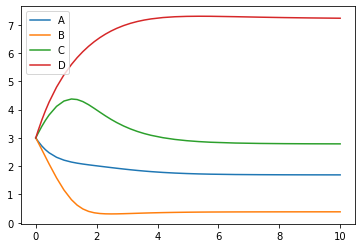

In [86]:
X0 = [3, 3, 3, 3]
time_span = [0, 10]

solution = solve_ivp(model, time_span, X0, method='BDF')

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2],
         solution.t, solution.y[3])

plt.legend(['A', 'B', 'C', 'D'])

In [70]:
def fluxes(t, X):

    A, B, C, D = X

    k1 = 5
    V2 = 20
    K2 = 2
    KI = 0.5
    V3 = 5
    K3 = 1
    kf = 0.1
    kr = 0.5
    V5 = 5
    K5 = 1
    k6 = 1
    k7 = 1
    
    r1 = k1
    r2 = V2 * (A / (K2 + A)) * (KI / (KI + C))
    r3 = V3 * (A / (K3 + A))
    r4 = kf * B - kr * D
    r5 = V5 * (B / (K5 + B))
    r6 = k6 * C
    r7 = k7 * D
    
    print(f'r1: {r1:.1f}')
    print(f'r2: {r2:.1f}')
    print(f'r3: {r3:.1f}')
    print(f'r4: {r4:.1f}')
    print(f'r5: {r5:.1f}')
    print(f'r6: {r6:.1f}')
    print(f'r7: {r7:.1f}')  
    
    dA = r1 - r2 - r3
    dB = r2 - r4 - r5
    dC = r5 - r6
    dD = r3 + r4 - r7
    
    return [dA, dB, dC, dD]

In [71]:
model(0, solution.y[:,-1])

[0.0006679432651726103,
 -3.346604444232071e-06,
 0.00028074030139535466,
 0.0007126189475963329]

In [72]:
fluxes(0, solution.y[:,-1])

r1: 5.0
r2: 1.8
r3: 3.2
r4: -0.2
r5: 2.0
r6: 2.0
r7: 2.9


[0.0006679432651726103,
 -3.346604444232071e-06,
 0.00028074030139535466,
 0.0007126189475963329]